# Разработка модели классификации на фродовые заказы


Ключевые этапы:
* Изучить предоставленные данные и провести первичный анализ (EDA).
* Разработать и обучить модель классификации (учитывая сильный дисбаланс классов 1:10).
* Оценить качество модели с фокусом на метрики для миноритарного класса.
* Реализовать прототип сервиса (django/FastAPI/Flask/Streamlit/Gradio или др.):
  * Принимает табличные данные,
  * Возвращает предсказанную метку и вероятность.
* Подготовить отчёт, описав подход, ключевые результаты и инструкцию по запуску.


## Структура данных

Датасет представлен в табличном формате и содержит следующие колонки:

`user_id` - идентификатор пользователя

`created_date` - дата создания записи

`nm_id` - идентификатор товара

`total_ordered` - общее количество заказанных товаров

`payment_type` - тип оплаты

`is_paid` - флаг оплаты (булево значение)

`count_items` - количество товаров за последнее время

`unique_items` - количество уникальных товаров за последнее время

`avg_unique_purchase` - среднее количество уникальных покупок за последнее время

`is_courier` - флаг доставки курьером

`nm_age` - возраст товара

`Distance` - расстояние

`days_after_registration` - дни после регистрации

`number_of_orders` - количество заказов

`number_of_ordered_items` - количество заказанных товаров

`mean_number_of_ordered_items` - среднее количество заказанных товаров

`min_number_of_ordered_items` - минимальное количество заказанных товаров

`max_number_of_ordered_items` - максимальное количество заказанных товаров

`mean_percent_of_ordered_items` - средний процент заказанных товаров

`target` - целевая переменная (0 - не требуется блокировка, 1 - требуется блокировка)

`service` - тип региона

Датасет имеет сильный дисбаланс классов в соотношении 1:10 (класс 1 встречается значительно реже).


## Требования к задаче

**Анализ данных (EDA):**
* Исследовать распределение признаков
* Проанализировать дисбаланс (сколько объектов каждого класса)
* Выявить корреляции между признаками
* Проверить наличие пропущенных значений и выбросов

**Предобработка данных:**
* Обработка пропущенных значений
* Кодирование категориальных признаков
* Масштабирование числовых признаков
* Работа с дисбалансом классов (SMOTE, undersampling, class weights и т.д.)

**Построение модели:**
* Любой фреймворк (scikit-learn, XGBoost, LightGBM, CatBoost и т.д.)
* Можно использовать ансамблевые методы
* Учитывать баланс между качеством и скоростью

**Оценка качества:**
* Основные метрики для миноритарного класса: Precision и Recall
* Дополнительные метрики: F1-score, PR-AUC, ROC-AUC
* Обязательная оценка Confusion Matrix

**Подготовка результатов:**
* Валидация: подбираем гиперпараметры
* Тест: итоговая метрика

**Развёртывание сервиса:**
* REST API (Flask/FastAPI) либо UI (Streamlit/Gradio)
* /predict эндпоинт, возвращающий {"prediction": 0 или 1, "confidence": float}

**Отчёт:**
* Описание подхода, модели, метрик
* Результаты на тесте


## Методика оценки

**Оценка качества модели для миноритарного (целевого) класса:**
* Неудовлетворительный результат:
  * Recall < 0.1 при Precision < 0.75
* Хороший результат:
  * 0.1 ≤ Recall при 0.8 ≤ Precision 
* Победитель:
  * Recall ≥ 0.1 при максимальном Precision

**Дополнительные метрики:**
* F1-score — комбинированная метрика Precision и Recall (используется для сравнения моделей)
* PR-AUC — особенно важна для несбалансированных данных
* ROC-AUC — оценка разделительной способности модели


### Рассмотрим распределение признаков

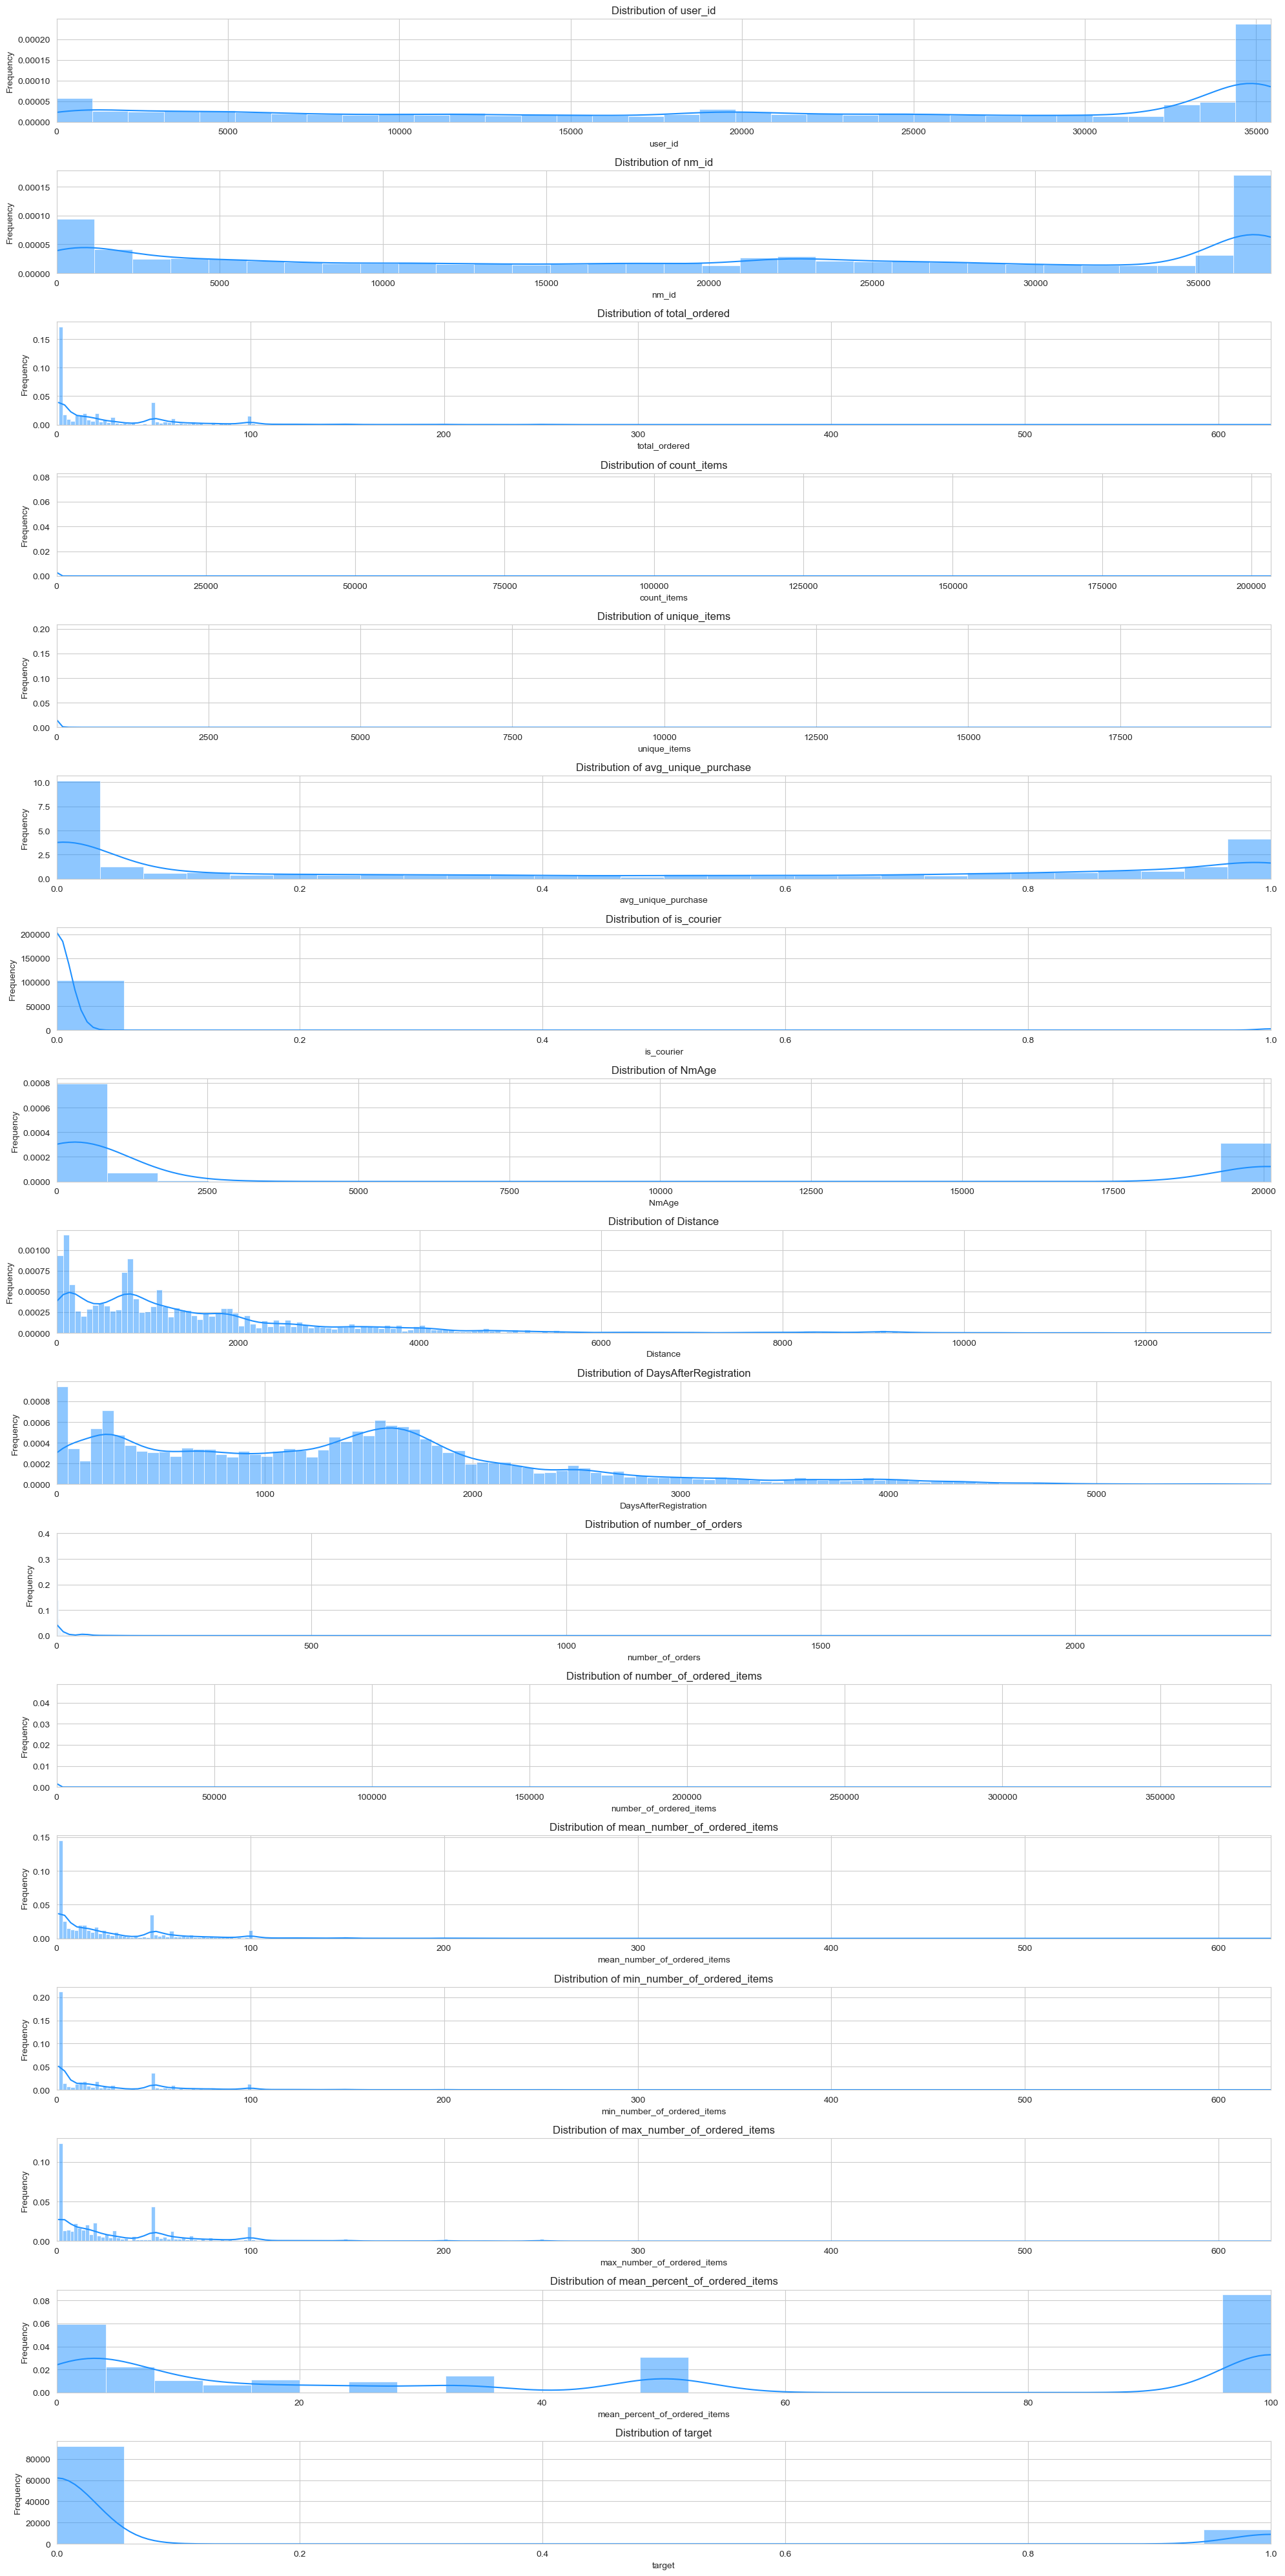

In [ ]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



data = pd.read_csv('df_train.csv')
# Distribution
# Setting the style for the plots
sns.set_style('whitegrid')

# Filtering out numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 40))

# Plotting histograms for each numerical column
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
        
    sns.histplot(
        data[col],
        color='dodgerblue',
        bins='auto',  #из-за этого долго считается
        kde=True,     
        edgecolor='white',  
        linewidth=0.5,      
        stat='density' if data[col].nunique() > 20 else 'count'  
    )
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
missing_values = data.isnull().sum() #Проверяю пропуски

data_types = data.dtypes

missing_values, data_types

(user_id                          0
 nm_id                            0
 CreatedDate                      0
 service                          0
 total_ordered                    0
 PaymentType                      0
 IsPaid                           0
 count_items                      0
 unique_items                     0
 avg_unique_purchase              0
 is_courier                       0
 NmAge                            0
 Distance                         0
 DaysAfterRegistration            0
 number_of_orders                 0
 number_of_ordered_items          0
 mean_number_of_ordered_items     0
 min_number_of_ordered_items      0
 max_number_of_ordered_items      0
 mean_percent_of_ordered_items    0
 target                           0
 dtype: int64,
 user_id                            int64
 nm_id                              int64
 CreatedDate                       object
 service                           object
 total_ordered                      int64
 PaymentType       